# Transient 1D Heat Transfer Tutorial Using DifferentialEquations.jl
# Extended with Non-Linear Dirichtlet Boundary Conditions 

## Import Packages 

In [1]:
using Ferrite
using SparseArrays
using LinearAlgebra         # provides mul! 
using UnPack                # added for time integration using DifferentialEquations.jl 
using OrdinaryDiffEq        # added for time integration using DifferentialEquations.jl
using DifferentialEquations # added for time integration using DifferentialEquations.jl
using WriteVTK
using Plots                 # provides contour plot of cell averages 

In [2]:
# import Pkg; Pkg.status() # uncomment to see version of package being used 

## Section 1: Introduction
We extend the heat transfer tutorial of Ferrite with time integration using DifferentialEquations.jl for the following three cases: 

1. Case (1/3): solve 1D heat equation on $\Omega = (0,1)$ with $u(x,t) = \sin(k \, \pi \, x) \, \exp(-k^2 \, \pi^2 \, t)$ with $f(x,t)=0$ and with hom. Dirichlet conditions and initial solution $u(x,0) = \sin(k \, \pi \, x)$;  
2. Case (2/3): solve 1D heat equation on $\Omega = (0,1)$ with time-dependent Dirichlet conditions with Dirichlet boundary condition $u(0) = 2$ and $u(1) = 0$ and source term $f(x,t) = 1 - x$ and initial condition $u(x,0) = 0$; 
3. Case (3/3): solve 1D heat equation on $\Omega = (0,1)$ with non-linear Dirichlet conditions;
   
(requires further elaboration).

<b>How to set non-zero initial guess?</b> Use apply_analytical? 

### Section 1.1: Model Problem 

<b>Motivation</b> The goal of this humble and noble endavor is to solve a heat equation with time-dependent Dirichlet boundary conditions. We therefore consider the model problem for the heat equation $u_t = u_{xx} + f(x,t)$ outlined below. 

<b>Problem Formulation</b> Assume that $0 \leq x \leq 1$ or that $x \in \Omega= [0,1]$ and that $0 \leq t \leq T$. Assume given the non-homogeneous $t$-dependent Dirichlet boundary conditions $u(0,t) = t$ and the homogeneous Dirichlet boundary conditions $u(1,t) = 0$. Assume given the source function $f(x,t) = f(x) = 1-x$. Then the function $u(x,t) = t \, (1-x)$ is the exact solution to the problem. The corresponding initial guess is zero. This model problem is an undressed baby version of the Incompressible Navier Stokes Tutoroial of Ferrite.jl in which the inlet conditions (here the boundary condition in $x=0$) for the velocity is ramped in time.  

<b>Spatial Discretization</b> We employ a classical method of lines approach in which the problem first discretizing the problem in space and subsequently in time. For spatial discretization, we employ a second order central finite difference (element?) scheme on a uniform mesh $\Omega^h$ with $N>1$ intervals, mesh width $h = 1/N$ and nodes $x_i = (i-1) \, h$ for $1 \leq i \leq N+1$. Assume that $K(t)$, $M(t)$ and ${\mathbf f}(t)$ denote the time-dependent $N+1$-by-$N+1$ stiffness matrix (thus including the boundary nodes), the $N+1$-by-$N+1$ mass matrix and $N+1$ load vector, respectively. (Requires elaborating how the boundary conditions are handled inside $K$ and $M$).  

<b>Temporal Discretization</b> Spatial discretization then results in a coupled system of ordinary differential equations 

$$
M \, \frac{d \, {\mathbf u}(t)}{dt} = K \, {\mathbf u}(t) + {\mathbf f}(t) 
\text{ supplied with the initial conditions } {\mathbf u}(0) = {\mathbf 0} \, . 
$$

Should we divide LHS and RHS by $M^{-1}$ and thus obtain an ODE that is more straightforward to treat? 

For temporal discretization, we employ DifferentialEquations.jl by defining the following two (or three?) functions 
1. the right-hand side function $\text{rhs}[{\mathbf u}(t)] = K \, {\mathbf u}(t) + {\mathbf f}(t)$ (plus handling of the boundary conditions?);
2. the Jacobian function $\text{jac}[{\mathbf u}(t)] = K$;
3. functionality for handling the time-dependent Dirichlet boundary conditions( either supplied as a limiter in the time-stepping algorithm, inside the RHS function or otherwise;

<b>Qiuestions</b>
1. examples in other codes?
2. 

## Section 2: Auxiliary Data Structures and Functions 

In [3]:
struct RHSparams
    K::SparseMatrixCSC
    f::Vector 
    ch::ConstraintHandler
    dh::DofHandler
    cvu::CellValues
    fvu::FacetValues
    u::Vector
end

## Section 3: Case (1/3): Mesh Generation, Spatial Discretization and Time Constants 

In [16]:
nels  = (10,)
left  = Vec((0.,))   # start point for geometry: lower-left point of the square 
right = Vec((1.,))   # end point for geometry: upper-right point of the square
grid  = generate_grid(Line, nels, left, right);
xgrid = Vector(0:(1/nels[1]):1.)

ip  = Lagrange{RefLine, 1}()
qr  = QuadratureRule{RefLine}(2)
ipg = Lagrange{RefLine,1}() # linear geometric interpolation
cvu = CellValues(qr, ip);
qr_facet = FacetQuadratureRule{RefLine}(2)
fvu      = FacetValues(qr_facet, ip, ipg) # required for inlet integral constraint

dh = DofHandler(grid)
add!(dh, :u, ip)
close!(dh);

K = allocate_matrix(dh);
M = allocate_matrix(dh);
f = zeros(ndofs(dh));

Δt = 0.02
T = 2
t_rise = 100
ch = ConstraintHandler(dh);

∂Ω₁ = getfacetset(grid, "left")
dbc1 = Dirichlet(:u, ∂Ω₁, (x, t) -> 2*(t*(t<=1)+(t>1)))
#dbc1 = Dirichlet(:u, ∂Ω₁, (x, t) -> t)
#dbc1 = Dirichlet(:u, ∂Ω₁, (x, t) -> 0) 
add!(ch, dbc1);

∂Ω₂ = getfacetset(grid, "right")
dbc2 = Dirichlet(:u, ∂Ω₂, (x, t) -> 0)
add!(ch, dbc2)
close!(ch)

update!(ch, 0.0);

In [17]:
# define spatially varying source functin 
function my_source(x)
    return 1-x[1]
end 

function assemble_K!(K::SparseMatrixCSC, f::Vector, cellvalues::CellValues, dh::DofHandler)

        n_basefuncs = getnbasefunctions(cellvalues)
        Ke = zeros(n_basefuncs, n_basefuncs)
        fe = zeros(n_basefuncs)

        assembler = start_assemble(K, f)

        for cell in CellIterator(dh)

            fill!(Ke, 0)
            fill!(fe, 0)

            cell_coords = getcoordinates(cell)
            Ferrite.reinit!(cellvalues, cell)

            for q_point in 1:getnquadpoints(cellvalues)
                dΩ = getdetJdV(cellvalues, q_point)

                for i in 1:n_basefuncs
                    coords_qp = spatial_coordinate(cellvalues, q_point, cell_coords)
                    source_qp = my_source(coords_qp)     
                    v = shape_value(cellvalues, q_point, i)
                    ∇v = shape_gradient(cellvalues, q_point, i)
                    fe[i] += source_qp * v * dΩ # 0.1 * v * dΩ
                    for j in 1:n_basefuncs
                        ∇u = shape_gradient(cellvalues, q_point, j)
                        Ke[i, j] += (∇v ⋅ ∇u) * dΩ
                    end
                end
            end

            assemble!(assembler, celldofs(cell), Ke, fe)
        end
        return K, f
end

function assemble_M!(M::SparseMatrixCSC, cellvalues::CellValues, dh::DofHandler)

    n_basefuncs = getnbasefunctions(cellvalues)
        Me = zeros(n_basefuncs, n_basefuncs)
        assembler = start_assemble(M)

        for cell in CellIterator(dh)
            fill!(Me, 0)
            Ferrite.reinit!(cellvalues, cell)
            for q_point in 1:getnquadpoints(cellvalues)
                dΩ = getdetJdV(cellvalues, q_point)

                for i in 1:n_basefuncs
                    v = shape_value(cellvalues, q_point, i)
                    for j in 1:n_basefuncs
                        u = shape_value(cellvalues, q_point, j)
                        Me[i, j] += (v * u) * dΩ
                    end
                end
            end

        assemble!(assembler, celldofs(cell), Me)
        end
            
        return M
end

assemble_M! (generic function with 1 method)

### Section 1.3: Intermediate testing 

In [18]:
#@code_warntype assemble_K!(K, f, cvu, dh)

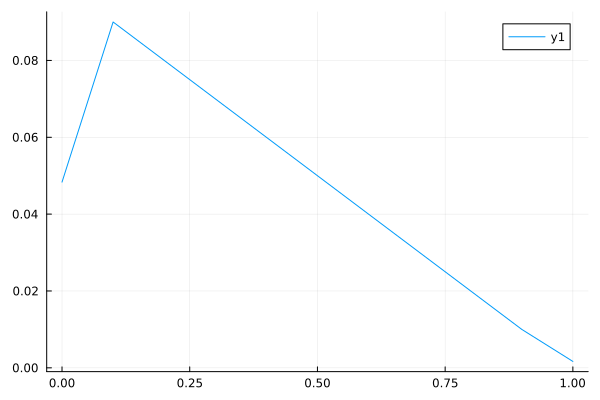

In [19]:
# test rhs-vector: should be (h)*f(x) 
K, f = assemble_K!(K, f, cvu, dh)
plot(xgrid,f)

## Section 4: Case (1/3): Static Solution for Various Time-Dependent Initial Conditions
This section should allow us to document how the updating of the boundary conditions works.  

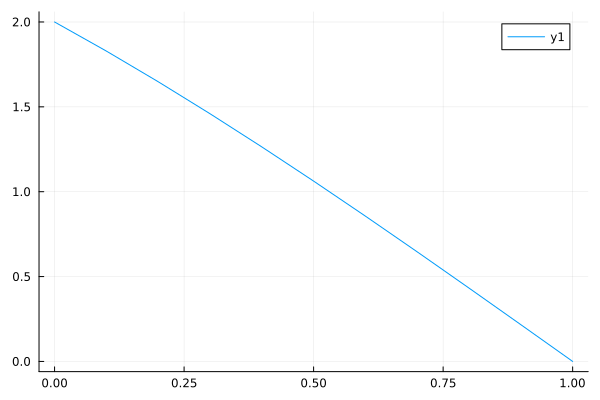

In [20]:
K, f = assemble_K!(K, f, cvu, dh)
M = assemble_M!(M, cvu, dh)
A = (Δt .* K) + M;
# We need to save all boundary condition related values of the unaltered system matrix A, which is done by get_rhs_data. 
# The function returns a RHSData struct, which contains all needed information to apply the boundary conditions solely on the 
# right-hand-side vector of the problem.
rhsdata = get_rhs_data(ch, A)

# shows how update works! 
update!(ch, 2)
# display(ch.prescribed_dofs) 
# display(ch.inhomogeneities) 

apply!(K, f, ch)
u = K \ f;

# set numerical solution at the nodes - applies reordering - out is a matrix
#u_computed_at_nodes = reshape_to_nodes(dh, u, :u)

plot(xgrid,u)

## Section 5: Hand-Coded Transient Loop

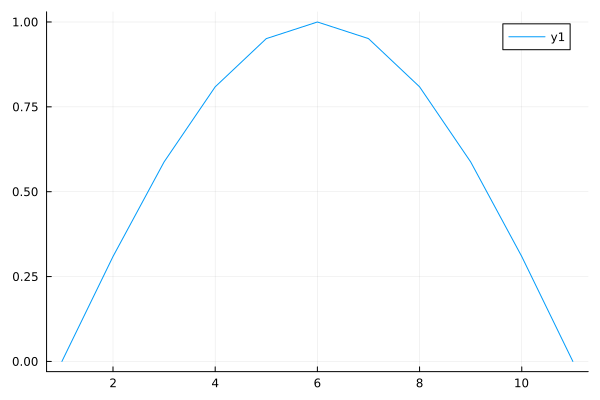

In [21]:
## does plotting of the solution after calling apply_analytical!() work well? Is this independent of the order of the elements? 
un = zeros(ndofs(dh))
apply_analytical!(un, dh, :u, x -> sin(pi*x[1]));
plot(un)

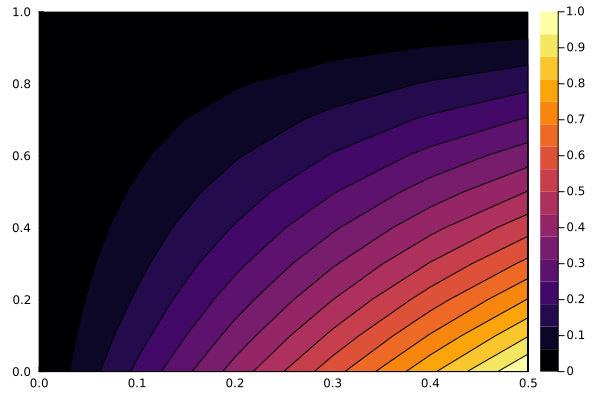

In [48]:
#..assemble stiffness matrix and load vector 
K, f = assemble_K!(K, f, cvu, dh)
#..assemble mass matrix 
M = assemble_M!(M, cvu, dh)
#..assemble time stepping matrix 
A = (Δt .* K) + M;
# We need to save all boundary condition related values of the unaltered system matrix A, which is done by get_rhs_data. 
# The function returns a RHSData struct, which contains all needed information to apply the boundary conditions solely on the 
# right-hand-side vector of the problem.
rhsdata = get_rhs_data(ch, A)
#..modify time-steppig matrix to take boundary conditions into account 
apply!(A, ch);

#..set time step and time interval 
Δt = 0.1
time_interval = 0:Δt:5*Δt 
#..set initial solution 
un            = zeros(ndofs(dh))
# apply_analytical!(un, dh, :u, x -> sin(pi*x[1]));
#..initialize matrix of solution history 
unhist        = zeros(ndofs(dh), length(time_interval))
unhist[:,1]   = un

#..initialize VTK file and write initial solution  
pvd = paraview_collection("transient-heat")
VTKGridFile("transient-heat-0", dh) do vtk
    write_solution(vtk, dh, un)
    pvd[0.0] = vtk
end

for (step, t) in enumerate(time_interval[2:end])
    # display(t)
    #..(1/7): update constraint-handler time-dependent Dirichlet boundary condition
    update!(ch, t)

    #..(2/7): compute time-dependent right-hand-side of the problem
    b = Δt .* f .+ M * un
    
    #..(3/7): apply the boundary conditions of the current time step
    apply_rhs!(rhsdata, b, ch)
    # b[1]=t

    #..(4/7): solve current time step
    u = A \ b

    #..(5/7): update previous solution
    un .= u 

    #..(6/7): store solution   
    unhist[:,step+1] = un

    #..(7/7): store store  
    #VTKGridFile("transient-heat-$step", dh) do vtk
    #    write_solution(vtk, dh, u)
    #    pvd[t] = vtk
    #end
end

contour(Vector(time_interval), xgrid, unhist, fill=true)

In [54]:
b = Δt .* f .+ M * un

11-element Vector{Float64}:
 0.05270219936909209
 0.09636215838128824
 0.08345152737925474
 0.07132926532666999
 0.059891026370289625
 0.04903405186814235
 0.03865743077257214
 0.028662174248005504
 0.018951102893607998
 0.00942856266439976
 0.0015688193296439596

In [55]:
apply_rhs!(rhsdata, b, ch)
b

11-element Vector{Float64}:
 1.8787878787878787
 1.0796954917146213
 0.08345152737925474
 0.07132926532666999
 0.059891026370289625
 0.04903405186814235
 0.03865743077257214
 0.028662174248005504
 0.018951102893607998
 0.00942856266439976
 0.0

In [53]:
?apply_rhs!

search: apply_rhs! apply_zero!



```
apply_rhs!(data::RHSData, f::AbstractVector, ch::ConstraintHandler, applyzero::Bool=false)
```

Applies the boundary condition to the right-hand-side vector without modifying the stiffness matrix.

See also: [`get_rhs_data`](@ref).


## Section 6: Case (1/3): Time-Integration Using DifferentialEquations.jl

Remark: Jacobian can be tested using finite differences. 

Q: how does time-step employed depend on value of the diffusion coefficient? 

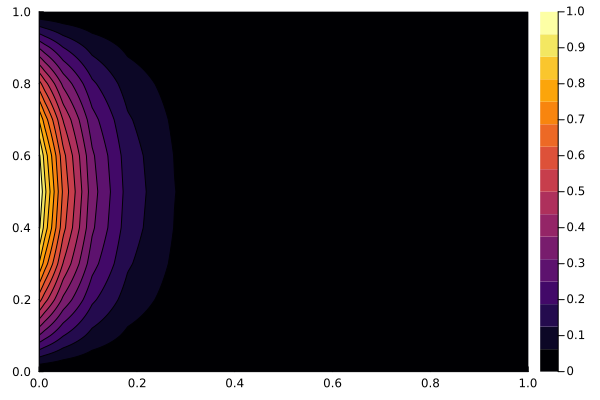

In [44]:
function my_rhs!(du, u, p, t)

    # display(t)

    # u[1] = t
    # Linear contribution (diffusion operator)
    # mul!(du, -K, u) # du .= K * u
    du .= -K * u  

    return
end

function my_jac!(J, u_uc, p::RHSparams, t)

    J .= -K 
    
    return     
end

# set time constants 
T   = 1.

# allocate, assemble and apply bc to mass matrix 
K, f = assemble_K!(K, f, cvu, dh)
M = assemble_M!(M, cvu, dh)
apply!(K, ch)
apply!(M, ch)

# set sparsity pattern 
jac_sparsity = sparse(K);

# set initial guess
uinit = zeros(ndofs(dh))
apply_analytical!(uinit, dh, :u, x -> sin(pi*x[1]))

# set parameters 
p = RHSparams(K, f, ch, dh, cvu, fvu, copy(uinit));

rhs = ODEFunction(my_rhs!, mass_matrix = M; jac = my_jac!, jac_prototype = jac_sparsity)
problem = ODEProblem(rhs, uinit, (0.0, T), p);
#sol = solve(problem, Rodas5(autodiff=AutoFiniteDiff(), step_limiter! = ferrite_limiter!), reltol = 1e-3, abstol = 1e-3); 
#sol = solve(problem, Rodas5(autodiff=false, step_limiter! = ferrite_limiter!), reltol = 1e-2, abstol = 1e-2);
sol = solve(problem, Rodas5(autodiff=false), reltol = 1e-2, abstol = 1e-2);

# post-processing 
dt = sol.t[2:end] - sol.t[1:end-1]
p1 = bar(sol.t[2:end],dt)

unhist = reduce(hcat,sol.u)
p2 = contour(sol.t,xgrid,unhist, fill=true)

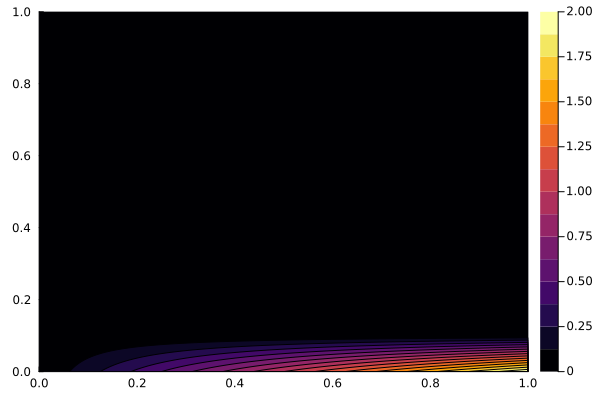

In [34]:
function heat_rhs!(du, u_uc, p::RHSparams, t)

    # display(t)

    @unpack K, f, ch, dh, cvu, fvu, u = p    

    u .= u_uc
    update!(ch, t)
    apply!(u, ch)
    # u[1] = t 

    # Linear contribution (diffusion operator)
    mul!(du, -K, u) # du .= K * u
    du
    # du .= -K * u 

    return
end

function heat_jac!(J, u_uc, p::RHSparams, t)

    @unpack K, f, ch, dh, cvu, fvu, u = p

    # update constraint handler 
    update!(ch, t)

    # Linear contribution (Stokes operator)
    # Here we assume that J has exactly the same structure as K by construction
    nonzeros(J) .= nonzeros(K)  

    return apply!(J, ch)    
end

function ferrite_limiter!(u, _, p, t)
    update!(p.ch, t)
    return apply!(u, p.ch)
end

# set time constants 
T   = 1.

# allocate, assemble and apply bc to mass matrix 
K, f = assemble_K!(K, f, cvu, dh)
M = assemble_M!(M, cvu, dh)
apply!(K, ch)
apply!(M, ch)

# set sparsity pattern 
jac_sparsity = sparse(K);

# set initial guess
uinit = zeros(ndofs(dh))
# apply_analytical!(uinit, dh, :u, x -> sin(pi*x[1]))

# set parameters 
p = RHSparams(K, f, ch, dh, cvu, fvu, copy(uinit));

rhs = ODEFunction(heat_rhs!, mass_matrix = M; jac = heat_jac!, jac_prototype = jac_sparsity)
problem = ODEProblem(rhs, uinit, (0.0, T), p);
#sol = solve(problem, Rodas5(autodiff=AutoFiniteDiff(), step_limiter! = ferrite_limiter!), reltol = 1e-3, abstol = 1e-3); 
sol = solve(problem, Rodas5(autodiff=false, step_limiter! = ferrite_limiter!), reltol = 1e-2, abstol = 1e-2);

# post-processing 
dt = sol.t[2:end] - sol.t[1:end-1]
p1 = bar(sol.t[2:end],dt)

unhist = reduce(hcat,sol.u)
p2 = contour(sol.t,xgrid,unhist, fill=true)

# plot(p1, p2, layout=(1,2))

In [54]:
sol.t

8-element Vector{Float64}:
 0.0
 1.0e-6
 1.1e-5
 0.00011099999999999999
 0.0011109999999999998
 0.0038798516497473108
 0.007093027921449689
 0.01

In [37]:
K*sol.u[end]

11-element Vector{Float64}:
 36.36363636363636
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0

In [ ]:
function ferrite_limiter!(u, _, p, t)
    update!(p.ch, t)
    return apply!(u, p.ch)
end

timestepper = Rodas5P(autodiff = false, step_limiter! = ferrite_limiter!);

integrator = init(
    problem, timestepper; initializealg = NoInit(), dt = Δt₀,
    adaptive = true, abstol = 1e5*1.0e-3, reltol = 1e5*1.0e-3,
    progress = true, progress_steps = 1,
    verbose = true, d_discontinuities = [100.0]
);

pvd = paraview_collection("transient-heat")
for (step, (u, t)) in enumerate(intervals(integrator))
    display(t)
    VTKGridFile("transient-heat-$step", dh) do vtk
        write_solution(vtk, dh, u)
        pvd[t] = vtk
    end
end

## Section 5: Case (2/2): Mesh Generation, Spatial Discretization and Time Constants 
Note that in Case (2/2) the left boundary is not included in the constraint handler. 

In [ ]:
nels = (40,20)
grid = generate_grid(Quadrilateral, nels);

ip  = Lagrange{RefQuadrilateral, 1}()
qr  = QuadratureRule{RefQuadrilateral}(2)
ipg = Lagrange{RefQuadrilateral,1}() # linear geometric interpolation
cvu = CellValues(qr, ip);
qr_facet = FacetQuadratureRule{RefQuadrilateral}(2)
fvu      = FacetValues(qr_facet, ip, ipg) # required for inlet integral constraint 

dh = DofHandler(grid)
add!(dh, :u, ip)
close!(dh);

K = allocate_matrix(dh);
M = allocate_matrix(dh);

f = zeros(ndofs(dh));

ch = ConstraintHandler(dh);

left_patch = getfacetset(dh.grid, "left")
∂Ω₂ = union(getfacetset.((grid,), ["top", "bottom", "right"])...)
dbc2 = Dirichlet(:u, ∂Ω₂, (x, t) -> 0)
add!(ch, dbc2)
close!(ch);

## Section 6: Case (2/2): Time-Integration Using DifferentialEquations.jl

In [ ]:
function assemble_K!(K::SparseMatrixCSC, f::Vector, cellvalues::CellValues, dh::DofHandler)

        n_basefuncs = getnbasefunctions(cellvalues)
        Ke = zeros(n_basefuncs, n_basefuncs)
        fe = zeros(n_basefuncs)

        assembler = start_assemble(K, f)

        for cell in CellIterator(dh)

            fill!(Ke, 0)
            fill!(fe, 0)

            Ferrite.reinit!(cellvalues, cell)

            for q_point in 1:getnquadpoints(cellvalues)
                dΩ = getdetJdV(cellvalues, q_point)

                for i in 1:n_basefuncs
                    v = shape_value(cellvalues, q_point, i)
                    ∇v = shape_gradient(cellvalues, q_point, i)
                    fe[i] += 0. * v * dΩ
                    for j in 1:n_basefuncs
                        ∇u = shape_gradient(cellvalues, q_point, j)
                        Ke[i, j] += 1e-1*(∇v ⋅ ∇u) * dΩ
                    end
                end
            end

            assemble!(assembler, celldofs(cell), Ke, fe)
        end
        return K, f
end

In [ ]:
t_rise = 1
res_functional(u,t) = u^2 - 2*(t*(t<=t_rise)+(t>t_rise))
dures_functional(u) = 2*u

function heat_rhs_element!(due, ue, fvu,t)
    n_basefuncs = getnbasefunctions(fvu)
    for qp in 1:getnquadpoints(fvu)
        dΓ = getdetJdV(fvu, qp)
        # evaluate function in quad point 
        u_qp = function_value(fvu, qp, ue)
        val_qp = res_functional(u_qp,t)
        for j in 1:n_basefuncs
            φⱼ = shape_value(fvu, qp, j)
            due[j] += val_qp*φⱼ*dΓ
        end
    end   
    # display(due)
    return 
end 
    
function heat_jac_element!(Je, ue, fvu)
    n_basefuncs = getnbasefunctions(fvu)
    for qp in 1:getnquadpoints(fvu)
        dΓ = getdetJdV(fvu, qp)
        # evaluate function in quad point 
        u_qp = function_value(fvu, qp, ue)
        duval_qp = dures_functional(u_qp)
        for j in 1:n_basefuncs
            φⱼ = shape_value(fvu, qp, j)
            for i in 1:n_basefuncs
                φᵢ = shape_value(fvu, qp, i)
                Je[j, i] += duval_qp*φᵢ*φⱼ* dΓ
            end
        end
    end   
    return 
end 

In [ ]:
function heat_rhs!(du, u_uc, p::RHSparams, t)

    # display(t)

    @unpack K, ch, dh, cvu, fvu, u = p    

    u .= u_uc
    update!(ch, t)
    apply!(u, ch)

    # Linear contribution 
    mul!(du, K, u) # du .= K * u

    # Non-Linear contribution 
    range_u = dof_range(dh, :u) 
    n_basefuncs = getnbasefunctions(cvu)
    ue  = zeros(n_basefuncs)
    due = zeros(n_basefuncs)

    for facet in FacetIterator(dh, left_patch)
        Ferrite.reinit!(fvu, facet)
        u_celldofs = @view celldofs(facet)[range_u]
        ue .= @views u[u_celldofs] # u is fetched outside of for-loop 
        fill!(due, 0)
        heat_rhs_element!(due, ue, fvu, t) # first argument is the input output argument 
        assemble!(du, u_celldofs, due) # add to previous values  
    end 
    
    return
end
    
function heat_jac!(J, u_uc, p::RHSparams, t)

    @unpack K, ch, dh, cvu, fvu, u = p    

    # update constraint handler 
    update!(ch, t)

    # Linear contribution (Stokes operator)
    # Here we assume that J has exactly the same structure as K by construction
    nonzeros(J) .= nonzeros(K)  

    assembler = start_assemble(J; fillzero = false)

    n_basefuncs = getnbasefunctions(cvu)
    ue  = zeros(n_basefuncs)
    Je  = zeros(n_basefuncs, n_basefuncs)
    due = zeros(n_basefuncs)
    range_u = dof_range(dh, :u) 

    for facet in FacetIterator(dh, left_patch)
        Ferrite.reinit!(fvu, facet)
        u_celldofs = @view celldofs(facet)[range_u]
        ue .= @views u[u_celldofs] # u is fetched outside of for-loop 
        fill!(Je, 0)
        heat_jac_element!(Je, ue, fvu) # first argument is the input output argument 
        assemble!(assembler, u_celldofs, Je) # add to previous values 
    end    

    return apply!(J, ch)    
end

In [ ]:
# test the RHS function 
du   = zeros(ndofs(dh));
u_uc = ones(ndofs(dh));
p    = RHSparams(K, ch, dh, cvu, fvu, copy(u_uc));

heat_rhs!(du, u_uc, p::RHSparams, 0.)
du;

In [ ]:
# test the Jacobian function
du   = zeros(ndofs(dh));
u_uc = ones(ndofs(dh));
p    = RHSparams(K, ch, dh, cvu, fvu, copy(u_uc));

J = allocate_matrix(dh,ch);
heat_jac!(J, u_uc, p::RHSparams, 0.)
J; 

In [ ]:
# set time constants 
T   = 2. 

# allocate, assemble and apply bc to mass matrix 
K, f = assemble_K!(K, f, cvu, dh)
M = assemble_M!(M, cvu, dh)
apply!(K, ch)
apply!(M, ch)

# set sparsity pattern 
jac_sparsity = sparse(K);

# set initial guess 
uinit = zeros(ndofs(dh))

# set parameters 
p = RHSparams(K, ch, dh, cvu, fvu, copy(uinit));

rhs = ODEFunction(heat_rhs!, mass_matrix = M; jac = heat_jac!, jac_prototype = jac_sparsity)
problem = ODEProblem(rhs, uinit, (0.0, T), p);
sol = solve(problem, Rodas5(autodiff=false), reltol = 1e-3, abstol = 1e-3)

# post-processing 
area, myu2d = mypostprocess(sol.u[end], dh, cvu, nels) 
contour(myu2d', fill=true, title="solution final time (elaborate)")

In [ ]:
function ferrite_limiter!(u, _, p, t)
    update!(p.ch, t)
    return apply!(u, p.ch)
end

timestepper = Rodas5P(autodiff = false, step_limiter! = ferrite_limiter!);

integrator = init(
    problem, timestepper; initializealg = NoInit(), dt = Δt₀,
    adaptive = true, abstol = 1.0e-3, reltol = 1.0e-3,
    progress = true, progress_steps = 1,
    verbose = true, d_discontinuities = [1.0]
);

pvd = paraview_collection("transient-heat")
for (step, (u, t)) in enumerate(intervals(integrator))
    display(t)
    VTKGridFile("transient-heat-$step", dh) do vtk
        write_solution(vtk, dh, u)
        pvd[t] = vtk
    end
end